# Случайные леса
__Суммарное количество баллов: 10__

В этом задании вам предстоит реализовать ансамбль деревьев решений, известный как случайный лес, применить его к публичным данным и сравнить его эффективность с ансамблями из самых популярных библиотек.

In [242]:
from sklearn.model_selection import train_test_split
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas as pd
from sklearn.neighbors import KDTree

In [243]:
def gini(x):
    p = np.bincount(x) / x.shape[0]
    g = np.sum(p * (1 - p))
    return g
    
def entropy(x):
    freq = np.bincount(x)
    freq = freq[freq != 0]
    p = freq / x.shape[0]
    e = -np.sum(p * np.log2(p))
    return e

def gain(left_y, right_y, criterion):
    total = np.concatenate([left_y, right_y])
    tc = criterion(total)
    lc = (left_y.shape[0] / total.shape[0]) * criterion(left_y)
    rc = (right_y.shape[0] / total.shape[0]) * criterion(right_y)
    ig = tc - lc - rc
    return ig

class DecisionTreeLeaf:
    def __init__(self, y):
        freq = np.bincount(y, minlength=2)
        self.y = np.argmax(freq)
        probs = freq / y.shape[0]
        self.class_probs = {i: p for i, p in enumerate(probs)}

class DecisionTreeNode:
    def __init__(self, split_dim, split_value, left, right, y):
        freq = np.bincount(y, minlength=2)
        self.y = np.argmax(freq)
        probs = freq / y.shape[0]
        self.class_probs = {i: p for i, p in enumerate(probs)}
        
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right

class DecisionTreeClassifier:
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1):
        self.root = None
        
        self.criterion = None
        if criterion == 'gini':
            self.criterion = gini
        elif criterion == 'entropy':
            self.criterion = entropy
        
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
    
    def fit(self, X, y):
        self.root = self.create_tree(X, y)
    
    def create_tree(self, X, y, depth=0):
        depth += 1
        if (self.max_depth is not None and depth >= self.max_depth) or y.shape[0] <= self.min_samples_leaf * 2 - 1 or np.unique(y).shape[0] == 1:
            return DecisionTreeLeaf(y)
        
        cols = X.shape[1]
        best_split_dim = None
        best_split_value = None
        best_ig = None
        best_argsort = None
        best_s = None
        
        for c in range(cols):
            argsort = np.argsort(X[:, c])
            X_sorted = X[argsort]
            y_sorted = y[argsort]
                        
            min_x = X_sorted[0, c]
            for s in range(self.min_samples_leaf, y_sorted.shape[0] - self.min_samples_leaf):
                if min_x < X_sorted[s, c]:
                    min_x = X_sorted[s, c]
                
                    left_y = y_sorted[:s]
                    right_y = y_sorted[s:]
                    ig = gain(left_y, right_y, self.criterion)

                    if (best_ig == None or ig > best_ig):
                        best_ig = ig
                        best_split_dim = c
                        best_split_value = X_sorted[s, c]
                        best_argsort = argsort
                        best_s = s
        if best_argsort is None:
            return DecisionTreeLeaf(y)
        else:
            left_X = X[best_argsort][:best_s, :]
            left_y = y[best_argsort][:best_s]
            left = self.create_tree(left_X, left_y, depth)

            right_X = X[best_argsort][best_s:, :]
            right_y = y[best_argsort][best_s:]
            right = self.create_tree(right_X, right_y, depth)

            return DecisionTreeNode(best_split_dim, best_split_value, left, right, y)
        
    
    def predict_proba(self, X, tree_depth_max=None):
        res = []
        for x in X:
            node = self.root
            if tree_depth_max is None:
                while not isinstance(node, DecisionTreeLeaf):
                    if x[node.split_dim] < node.split_value:
                        node = node.left
                    else:
                        node = node.right
                res.append(node.class_probs)
            else:
                i = 0
                while i < tree_depth_max and not isinstance(node, DecisionTreeLeaf):
                    if x[node.split_dim] < node.split_value:
                        node = node.left
                    else:
                        node = node.right
                    i += 1
                res.append(node.class_probs)
        return res
    
    def predict(self, X, tree_depth_max=None):
        proba = self.predict_proba(X, tree_depth_max)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]

### Задание 1 (3 балла)
Реализуем сам Random Forest. Идея очень простая: строим `n` деревьев, а затем берем модальное предсказание. Используйте реализацию дерева из HW3.

#### Параметры конструктора
`n_estimators` - количество используемых для предсказания деревьев.

Остальное - параметры деревьев.

#### Методы
`fit(X, y)` - строит `n_estimators` деревьев по выборке `X`.

`predict(X)` - для каждого элемента выборки `X` возвращает самый частый класс, который предсказывают для него деревья.

In [244]:
class RandomForestClassifier:
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1, max_features="auto", n_estimators=10):
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.n_estimators = n_estimators
        self.trees = []
    
    def fit(self, X, y):
        self.C = len(np.unique(y))
        self.X = X.copy()
        self.y = y.copy()
        self.trees = []
        self.ids = []
        for _ in range(self.n_estimators):
            ids = random.choices(population=range(y.shape[0]), k=y.shape[0])
            tree = DecisionTreeClassifier(criterion=self.criterion, max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf)
            
            tree.fit(X[ids], y[ids])
            self.trees.append(tree)
            self.ids.append(ids)
    
    def predict_proba(self, X, tree_depth_max=None):
        res = []
        for t in self.trees:
            res.append(t.predict(X, tree_depth_max))
        res = np.array(res)
        bins = np.apply_along_axis(np.bincount, 0, res, minlength=self.C)
        rp = bins / np.sum(bins, axis=0)
        
        pres = []
        for i in range(rp.shape[1]):
            pres.append({0: rp[0][i], 1: rp[1][i]})
        
        return pres
    
    def predict(self, X, tree_depth_max=None):
        res = []
        for t in self.trees:
            res.append(t.predict(X, tree_depth_max))
        res = np.array(res)
        bins = np.apply_along_axis(np.bincount, 0, res, minlength=self.C)
        res_r = np.argmax(bins, axis=0)
        return res_r

### Задание 3 (2 балла)
Оптимизируйте по `AUC` на кроссвалидации (размер валидационной выборки - 20%) параметры своей реализации `Random Forest`: 

максимальную глубину деревьев из [2, 3, 5, 7, 10], количество деревьев из [5, 10, 20, 30, 50, 100]. 

Постройте `ROC` кривую (и выведите `AUC` и `accuracy`) для лучшего варианта.

Подсказка: можно построить сразу 100 деревьев глубины 10, а потом убирать деревья и
глубину.

In [245]:
spam = pd.read_csv('hw2_data/spam.csv')
X = spam.drop(columns='label').to_numpy()
y = spam.label.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cl = RandomForestClassifier(max_depth=2, min_samples_leaf=30, n_estimators=3)
cl.fit(X_train, y_train)
y_pred = cl.predict(X_test, 3)

In [246]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, accuracy_score

splits = 5

kf = KFold(n_splits=splits)

max_depth = [2, 3, 5, 7, 10]
n_estimators = [5, 10, 20, 30, 50, 100]

res = []


cls = []
valdf = []
i = 1
for train_index, test_index in kf.split(X_train):
    print(i, '/', splits)
    X_train2 = X_train[train_index]
    y_train2 = y_train[train_index]
    X_valid = X_train[test_index]
    y_valid = y_train[test_index]

    cl = RandomForestClassifier(max_depth=max(max_depth), n_estimators=max(n_estimators))
    cl.fit(X_train2, y_train2)
    cls.append(cl)
    valdf.append((X_valid, y_valid))
    i += 1


for md in max_depth:
#     print('depth:', md)
    for ne in sorted(n_estimators, reverse=True):
#         print('n_estimators', ne)
        
        aucs = []
        
        for i, cl in enumerate(cls):
            cl.trees = cl.trees[:ne]
            y_pred = cl.predict(valdf[i][0], md)
            aucs.append(roc_auc_score(valdf[i][1], y_pred))
        
        auc = np.mean(aucs)
        
        print(auc, md, ne)
        res.append((auc, md, ne))

1 / 5
2 / 5
3 / 5
4 / 5
5 / 5
0.8429173473875888 2 100
0.8477490167952304 2 50
0.847155597478419 2 30
0.8423675472601599 2 20
0.8356186492260222 2 10
0.8422224018116916 2 5
0.8807502822530298 3 100
0.8807502822530298 3 50
0.8807502822530298 3 30
0.8807502822530298 3 20
0.8807502822530298 3 10
0.8807502822530298 3 5
0.9003900054701042 5 100
0.9003900054701042 5 50
0.9003900054701042 5 30
0.9003900054701042 5 20
0.9003900054701042 5 10
0.9003900054701042 5 5
0.9103945013710699 7 100
0.9103945013710699 7 50
0.9103945013710699 7 30
0.9103945013710699 7 20
0.9103945013710699 7 10
0.9103945013710699 7 5
0.9141439576028094 10 100
0.9141439576028094 10 50
0.9141439576028094 10 30
0.9141439576028094 10 20
0.9141439576028094 10 10
0.9141439576028094 10 5


In [247]:
max(res)

(0.9141439576028094, 10, 100)

In [248]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

In [249]:
best = RandomForestClassifier(max_depth=10, n_estimators=100)
best.fit(X_train, y_train)
y_pred = best.predict(X_test)
print('accuracy:', accuracy_score(y_test, y_pred))
print('auc:', roc_auc_score(y_test, y_pred))

accuracy: 0.9229098805646037
auc: 0.9137404027234535


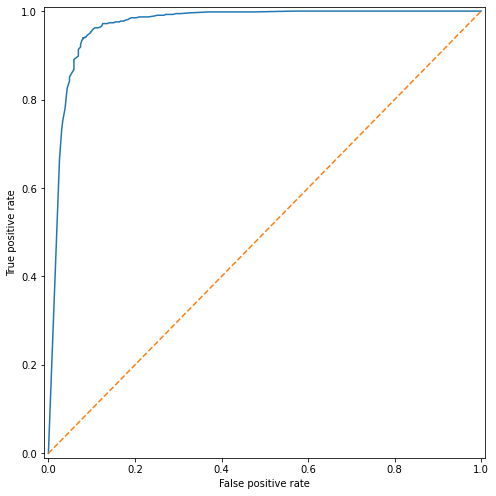

In [250]:
plot_roc_curve(y_test, best.predict_proba(X_test))

### Задание 4 (3 балла)
Часто хочется понимать, насколько большую роль играет тот или иной признак для предсказания класса объекта. Есть различные способы посчитать его важность. Один из простых способов сделать это для Random Forest выглядит так:
1. Посчитать out-of-bag ошибку предсказания `err_oob` (https://en.wikipedia.org/wiki/Out-of-bag_error)
2. Перемешать значения признака `j` у объектов выборки (у каждого из объектов изменится значение признака `j` на какой-то другой)
3. Посчитать out-of-bag ошибку (`err_oob_j`) еще раз.
4. Оценкой важности признака `j` для одного дерева будет разность `err_oob_j - err_oob`, важность для всего леса считается как среднее значение важности по деревьям.

Реализуйте функцию `feature_importance`, которая принимает на вход Random Forest и возвращает массив, в котором содержится важность для каждого признака.

In [206]:
def oob_err(rfc):
    total = 0
    error = 0
    
    for i, x in enumerate(rfc.X):
        pr = []
        for j, ids in enumerate(rfc.ids):
            if i not in ids:
                p = rfc.trees[j].predict(np.array([x]))
                pr.append(p[0])
        if len(pr) > 0:
            c = np.argmax(np.bincount(pr))
            if c != rfc.y[i]:
                error += 1
            total += 1
    
    return error / total

def feature_importance(rfc):
    err_oob = oob_err(rfc)
    X = rfc.X.copy()
    
    imp = []
    
    for j in range(X.shape[1]):
        Xj = X.copy()
        np.random.shuffle(Xj[:, j])
        rfc.X = Xj
        err_oob_j = oob_err(rfc)
        imp.append(err_oob_j - err_oob)
    
    return imp

def most_important_features(importance, names, k=20):
    # Выводит названия k самых важных признаков
    idicies = np.argsort(importance)[::-1][:k]
    return np.array(names)[idicies]

Протестируйте решение на простом синтетическом наборе данных. В результате должна получиться точность `1.0`, наибольшее значение важности должно быть у признака с индексом `4`, признаки с индексами `2` и `3`  должны быть одинаково важны, а остальные признаки - не важны совсем.

In [207]:
def synthetic_dataset(size):
    X = [(np.random.randint(0, 2), np.random.randint(0, 2), i % 6 == 3, 
          i % 6 == 0, i % 3 == 2, np.random.randint(0, 2)) for i in range(size)]
    y = [i % 3 for i in range(size)]
    return np.array(X), np.array(y)

X, y = synthetic_dataset(1000)
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X, y)
print("Accuracy:", np.mean(rfc.predict(X) == y))
print("Importance:", feature_importance(rfc))

Accuracy: 1.0
Importance: [0.0, 0.0, 0.2, 0.195, 0.446, 0.0]


Проверьте, какие признаки важны для датасетов cancer и spam?

In [253]:
spam = pd.read_csv('hw2_data/spam.csv')
X = spam.drop(columns='label').to_numpy()
y = spam.label.to_numpy()
X_train_spam, X_test_spam, y_train_spam, y_test_spam = train_test_split(X, y, test_size=0.2, random_state=42)

rfc = RandomForestClassifier(max_depth=10, n_estimators=30)
rfc.fit(X_train_spam, y_train_spam)

imp = feature_importance(rfc)
names = list(spam.columns)
names.remove('label')
most_important_features(imp, names, k=10)

array(['word_freq_remove', 'word_freq_hp', 'word_freq_george',
       'capital_run_length_longest', 'char_freq_$', 'char_freq_!',
       'word_freq_edu', 'word_freq_free', 'capital_run_length_total',
       'word_freq_money'], dtype='<U26')

In [254]:
cancer = pd.read_csv('hw2_data/cancer.csv')
X = cancer.drop(columns='label').to_numpy()
y = (cancer['label'].to_numpy() == 'M').astype(int)
X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = train_test_split(X, y, test_size=0.2, random_state=42)

rfc = RandomForestClassifier(max_depth=10, n_estimators=30)
rfc.fit(X_train_cancer, y_train_cancer)

imp = feature_importance(rfc)
names = list(cancer.columns)
names.remove('label')
most_important_features(imp, names, k=10)

array(['28', '21', '8', '24', '27', '1', '2', '23', '11', '13'],
      dtype='<U2')

### Задание 5 (2 балла)
В качестве альтернативы попробуем библиотечные реализации ансамблей моделей. 

1. [CatBoost](https://catboost.ai/docs/)
2. [XGBoost](https://xgboost.readthedocs.io/en/latest/)
3. [LightGBM](https://lightgbm.readthedocs.io/en/latest/)


Установите необходимые библиотеки. 
Возможно, потребуется установка дополнительных пакетов

In [231]:
import lightgbm
import catboost
import xgboost as xgb

Также, как и реализованный нами RandomForest, примените модели для наших датасетов.

Для стандартного набора параметров у каждой модели нарисуйте `ROC` кривую и выведите `AUC` и `accuracy`.

Посчитайте время обучения каждой модели (можно использовать [timeit magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit)). 

Сравните метрики качества и скорость обучения моделей. Какие выводы можно сделать?

Lightbtm

In [220]:
%%time
cl = lightgbm.LGBMClassifier()
cl.fit(X_train_spam, y_train_spam)

CPU times: user 2.47 s, sys: 112 ms, total: 2.58 s
Wall time: 259 ms


LGBMClassifier()

accuracy: 0.9663409337676439
auc: 0.9633202955236854


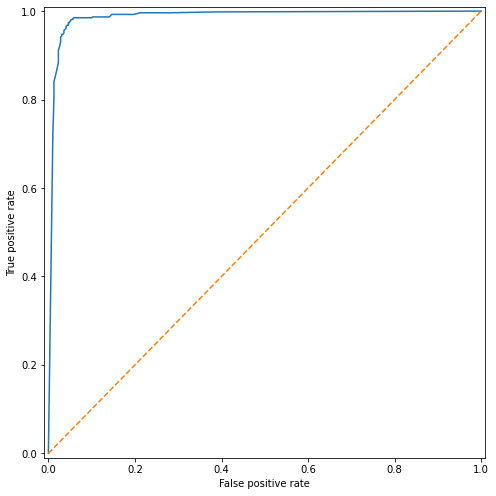

In [223]:
y_pred = cl.predict(X_test_spam)
print('accuracy:', accuracy_score(y_test_spam, y_pred))
print('auc:', roc_auc_score(y_test_spam, y_pred))
probs = cl.predict_proba(X_test_spam)
rows, cols = probs.shape
probs_d = [{ j: probs[i, j] for j in range(cols) } for i in range(rows)]
plot_roc_curve(y_test_spam, probs_d)

In [224]:
%%time
cl = lightgbm.LGBMClassifier()
cl.fit(X_train_cancer, y_train_cancer)

CPU times: user 739 ms, sys: 31 ms, total: 770 ms
Wall time: 75.9 ms


LGBMClassifier()

accuracy: 0.9649122807017544
auc: 0.9580740255486406


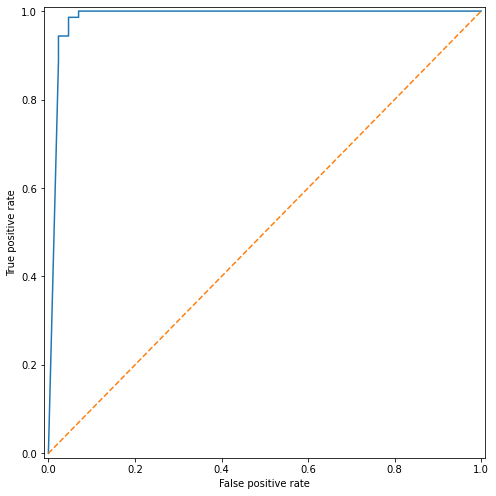

In [225]:
y_pred = cl.predict(X_test_cancer)
print('accuracy:', accuracy_score(y_test_cancer, y_pred))
print('auc:', roc_auc_score(y_test_cancer, y_pred))
probs = cl.predict_proba(X_test_cancer)
rows, cols = probs.shape
probs_d = [{ j: probs[i, j] for j in range(cols) } for i in range(rows)]
plot_roc_curve(y_test_cancer, probs_d)

catboost

In [229]:
%%time
cl = catboost.CatBoostClassifier()
cl.fit(X_train_spam, y_train_spam)

Learning rate set to 0.01797
0:	learn: 0.6712954	total: 8.61ms	remaining: 8.6s
1:	learn: 0.6524123	total: 15.6ms	remaining: 7.79s
2:	learn: 0.6338321	total: 21.7ms	remaining: 7.2s
3:	learn: 0.6150818	total: 26.1ms	remaining: 6.49s
4:	learn: 0.5983657	total: 30.7ms	remaining: 6.11s
5:	learn: 0.5811688	total: 34.6ms	remaining: 5.73s
6:	learn: 0.5632164	total: 38.8ms	remaining: 5.5s
7:	learn: 0.5456946	total: 42.4ms	remaining: 5.26s
8:	learn: 0.5295430	total: 47.1ms	remaining: 5.18s
9:	learn: 0.5151267	total: 51.6ms	remaining: 5.11s
10:	learn: 0.5047861	total: 55.6ms	remaining: 5s
11:	learn: 0.4924422	total: 59ms	remaining: 4.86s
12:	learn: 0.4783559	total: 62.3ms	remaining: 4.73s
13:	learn: 0.4665455	total: 65.8ms	remaining: 4.63s
14:	learn: 0.4570336	total: 69.2ms	remaining: 4.54s
15:	learn: 0.4460645	total: 72.3ms	remaining: 4.45s
16:	learn: 0.4368568	total: 75.5ms	remaining: 4.37s
17:	learn: 0.4280305	total: 78.7ms	remaining: 4.29s
18:	learn: 0.4176713	total: 82.1ms	remaining: 4.24s
1

199:	learn: 0.1408442	total: 770ms	remaining: 3.08s
200:	learn: 0.1406340	total: 774ms	remaining: 3.08s
201:	learn: 0.1404763	total: 781ms	remaining: 3.08s
202:	learn: 0.1402665	total: 785ms	remaining: 3.08s
203:	learn: 0.1400517	total: 789ms	remaining: 3.08s
204:	learn: 0.1397955	total: 794ms	remaining: 3.08s
205:	learn: 0.1396078	total: 798ms	remaining: 3.08s
206:	learn: 0.1395427	total: 802ms	remaining: 3.07s
207:	learn: 0.1394381	total: 806ms	remaining: 3.07s
208:	learn: 0.1391872	total: 810ms	remaining: 3.07s
209:	learn: 0.1389016	total: 814ms	remaining: 3.06s
210:	learn: 0.1387331	total: 819ms	remaining: 3.06s
211:	learn: 0.1385471	total: 822ms	remaining: 3.05s
212:	learn: 0.1384761	total: 826ms	remaining: 3.05s
213:	learn: 0.1383682	total: 829ms	remaining: 3.05s
214:	learn: 0.1380974	total: 834ms	remaining: 3.04s
215:	learn: 0.1379686	total: 837ms	remaining: 3.04s
216:	learn: 0.1376976	total: 842ms	remaining: 3.04s
217:	learn: 0.1374675	total: 845ms	remaining: 3.03s
218:	learn: 

388:	learn: 0.1150983	total: 1.55s	remaining: 2.43s
389:	learn: 0.1150781	total: 1.55s	remaining: 2.42s
390:	learn: 0.1149748	total: 1.56s	remaining: 2.42s
391:	learn: 0.1149126	total: 1.56s	remaining: 2.42s
392:	learn: 0.1148355	total: 1.57s	remaining: 2.42s
393:	learn: 0.1147709	total: 1.57s	remaining: 2.42s
394:	learn: 0.1147501	total: 1.57s	remaining: 2.41s
395:	learn: 0.1145199	total: 1.58s	remaining: 2.41s
396:	learn: 0.1143810	total: 1.58s	remaining: 2.4s
397:	learn: 0.1142019	total: 1.59s	remaining: 2.4s
398:	learn: 0.1141798	total: 1.59s	remaining: 2.4s
399:	learn: 0.1141541	total: 1.59s	remaining: 2.39s
400:	learn: 0.1140944	total: 1.6s	remaining: 2.39s
401:	learn: 0.1139649	total: 1.6s	remaining: 2.38s
402:	learn: 0.1137827	total: 1.61s	remaining: 2.38s
403:	learn: 0.1136799	total: 1.61s	remaining: 2.38s
404:	learn: 0.1134800	total: 1.61s	remaining: 2.37s
405:	learn: 0.1134518	total: 1.62s	remaining: 2.37s
406:	learn: 0.1133711	total: 1.62s	remaining: 2.36s
407:	learn: 0.113

568:	learn: 0.0998432	total: 2.32s	remaining: 1.75s
569:	learn: 0.0997643	total: 2.32s	remaining: 1.75s
570:	learn: 0.0997568	total: 2.32s	remaining: 1.75s
571:	learn: 0.0997456	total: 2.33s	remaining: 1.74s
572:	learn: 0.0996124	total: 2.33s	remaining: 1.74s
573:	learn: 0.0995189	total: 2.33s	remaining: 1.73s
574:	learn: 0.0993879	total: 2.34s	remaining: 1.73s
575:	learn: 0.0993398	total: 2.34s	remaining: 1.72s
576:	learn: 0.0992201	total: 2.34s	remaining: 1.72s
577:	learn: 0.0991085	total: 2.35s	remaining: 1.71s
578:	learn: 0.0990968	total: 2.35s	remaining: 1.71s
579:	learn: 0.0990872	total: 2.35s	remaining: 1.7s
580:	learn: 0.0989968	total: 2.36s	remaining: 1.7s
581:	learn: 0.0988284	total: 2.36s	remaining: 1.7s
582:	learn: 0.0988199	total: 2.37s	remaining: 1.69s
583:	learn: 0.0986541	total: 2.37s	remaining: 1.69s
584:	learn: 0.0986442	total: 2.37s	remaining: 1.68s
585:	learn: 0.0985962	total: 2.37s	remaining: 1.68s
586:	learn: 0.0985187	total: 2.38s	remaining: 1.67s
587:	learn: 0.0

767:	learn: 0.0838287	total: 3.08s	remaining: 931ms
768:	learn: 0.0837413	total: 3.09s	remaining: 927ms
769:	learn: 0.0837208	total: 3.09s	remaining: 923ms
770:	learn: 0.0837006	total: 3.1s	remaining: 920ms
771:	learn: 0.0836591	total: 3.1s	remaining: 916ms
772:	learn: 0.0835362	total: 3.1s	remaining: 912ms
773:	learn: 0.0835309	total: 3.11s	remaining: 908ms
774:	learn: 0.0833371	total: 3.11s	remaining: 904ms
775:	learn: 0.0832555	total: 3.12s	remaining: 899ms
776:	learn: 0.0831694	total: 3.12s	remaining: 896ms
777:	learn: 0.0829990	total: 3.12s	remaining: 891ms
778:	learn: 0.0829937	total: 3.13s	remaining: 887ms
779:	learn: 0.0828726	total: 3.13s	remaining: 883ms
780:	learn: 0.0828444	total: 3.13s	remaining: 879ms
781:	learn: 0.0828006	total: 3.14s	remaining: 875ms
782:	learn: 0.0827726	total: 3.14s	remaining: 870ms
783:	learn: 0.0827675	total: 3.14s	remaining: 866ms
784:	learn: 0.0826740	total: 3.15s	remaining: 862ms
785:	learn: 0.0825847	total: 3.15s	remaining: 858ms
786:	learn: 0.0

976:	learn: 0.0707886	total: 3.85s	remaining: 90.7ms
977:	learn: 0.0706683	total: 3.86s	remaining: 86.7ms
978:	learn: 0.0706560	total: 3.86s	remaining: 82.8ms
979:	learn: 0.0705949	total: 3.86s	remaining: 78.8ms
980:	learn: 0.0705908	total: 3.87s	remaining: 74.9ms
981:	learn: 0.0705215	total: 3.87s	remaining: 70.9ms
982:	learn: 0.0705168	total: 3.87s	remaining: 67ms
983:	learn: 0.0704554	total: 3.88s	remaining: 63ms
984:	learn: 0.0703983	total: 3.88s	remaining: 59.1ms
985:	learn: 0.0703677	total: 3.88s	remaining: 55.2ms
986:	learn: 0.0703594	total: 3.89s	remaining: 51.2ms
987:	learn: 0.0702982	total: 3.89s	remaining: 47.3ms
988:	learn: 0.0702169	total: 3.9s	remaining: 43.3ms
989:	learn: 0.0701459	total: 3.9s	remaining: 39.4ms
990:	learn: 0.0700670	total: 3.9s	remaining: 35.4ms
991:	learn: 0.0700077	total: 3.91s	remaining: 31.5ms
992:	learn: 0.0699973	total: 3.91s	remaining: 27.6ms
993:	learn: 0.0699934	total: 3.91s	remaining: 23.6ms
994:	learn: 0.0699426	total: 3.92s	remaining: 19.7ms


accuracy: 0.9598262757871878
auc: 0.9569897146168332


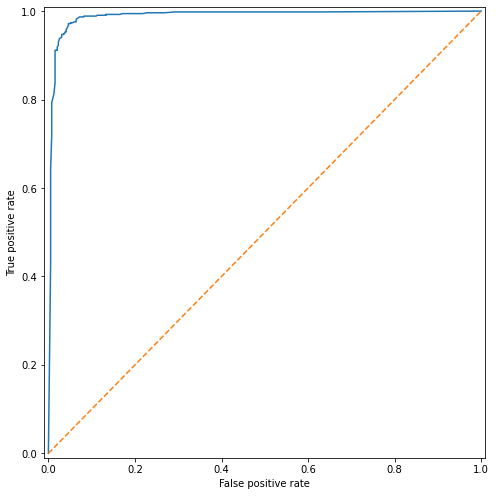

In [230]:
y_pred = cl.predict(X_test_spam)
print('accuracy:', accuracy_score(y_test_spam, y_pred))
print('auc:', roc_auc_score(y_test_spam, y_pred))
probs = cl.predict_proba(X_test_spam)
rows, cols = probs.shape
probs_d = [{ j: probs[i, j] for j in range(cols) } for i in range(rows)]
plot_roc_curve(y_test_spam, probs_d)

In [226]:
%%time
cl = catboost.CatBoostClassifier()
cl.fit(X_train_cancer, y_train_cancer)

Learning rate set to 0.00736
0:	learn: 0.6812692	total: 56.4ms	remaining: 56.3s
1:	learn: 0.6692551	total: 58.9ms	remaining: 29.4s
2:	learn: 0.6584064	total: 61.2ms	remaining: 20.3s
3:	learn: 0.6482301	total: 63.9ms	remaining: 15.9s
4:	learn: 0.6375533	total: 66.2ms	remaining: 13.2s
5:	learn: 0.6284459	total: 68.9ms	remaining: 11.4s
6:	learn: 0.6166395	total: 72.1ms	remaining: 10.2s
7:	learn: 0.6065143	total: 75.3ms	remaining: 9.34s
8:	learn: 0.5956138	total: 79.3ms	remaining: 8.73s
9:	learn: 0.5863199	total: 82.5ms	remaining: 8.17s
10:	learn: 0.5759723	total: 85.9ms	remaining: 7.72s
11:	learn: 0.5666277	total: 89ms	remaining: 7.33s
12:	learn: 0.5565833	total: 91.8ms	remaining: 6.97s
13:	learn: 0.5481102	total: 96.3ms	remaining: 6.78s
14:	learn: 0.5396832	total: 98.8ms	remaining: 6.49s
15:	learn: 0.5312289	total: 102ms	remaining: 6.28s
16:	learn: 0.5238478	total: 105ms	remaining: 6.05s
17:	learn: 0.5156343	total: 107ms	remaining: 5.84s
18:	learn: 0.5084475	total: 110ms	remaining: 5.67s

226:	learn: 0.0748877	total: 557ms	remaining: 1.9s
227:	learn: 0.0744827	total: 560ms	remaining: 1.9s
228:	learn: 0.0741614	total: 563ms	remaining: 1.9s
229:	learn: 0.0737900	total: 566ms	remaining: 1.89s
230:	learn: 0.0735072	total: 570ms	remaining: 1.9s
231:	learn: 0.0730087	total: 573ms	remaining: 1.9s
232:	learn: 0.0725789	total: 575ms	remaining: 1.89s
233:	learn: 0.0721050	total: 578ms	remaining: 1.89s
234:	learn: 0.0717394	total: 580ms	remaining: 1.89s
235:	learn: 0.0714289	total: 582ms	remaining: 1.89s
236:	learn: 0.0709475	total: 586ms	remaining: 1.89s
237:	learn: 0.0706366	total: 589ms	remaining: 1.88s
238:	learn: 0.0703060	total: 592ms	remaining: 1.89s
239:	learn: 0.0699545	total: 595ms	remaining: 1.88s
240:	learn: 0.0695326	total: 597ms	remaining: 1.88s
241:	learn: 0.0692192	total: 601ms	remaining: 1.88s
242:	learn: 0.0688242	total: 607ms	remaining: 1.89s
243:	learn: 0.0685238	total: 611ms	remaining: 1.89s
244:	learn: 0.0682585	total: 617ms	remaining: 1.9s
245:	learn: 0.0679

392:	learn: 0.0375634	total: 1.12s	remaining: 1.73s
393:	learn: 0.0374454	total: 1.12s	remaining: 1.73s
394:	learn: 0.0373096	total: 1.13s	remaining: 1.73s
395:	learn: 0.0372326	total: 1.13s	remaining: 1.73s
396:	learn: 0.0370997	total: 1.14s	remaining: 1.72s
397:	learn: 0.0369889	total: 1.14s	remaining: 1.72s
398:	learn: 0.0368708	total: 1.14s	remaining: 1.72s
399:	learn: 0.0367665	total: 1.14s	remaining: 1.71s
400:	learn: 0.0366790	total: 1.14s	remaining: 1.71s
401:	learn: 0.0365369	total: 1.15s	remaining: 1.71s
402:	learn: 0.0364545	total: 1.15s	remaining: 1.7s
403:	learn: 0.0363625	total: 1.15s	remaining: 1.7s
404:	learn: 0.0362937	total: 1.15s	remaining: 1.7s
405:	learn: 0.0361573	total: 1.16s	remaining: 1.69s
406:	learn: 0.0360531	total: 1.16s	remaining: 1.69s
407:	learn: 0.0359184	total: 1.16s	remaining: 1.68s
408:	learn: 0.0357907	total: 1.16s	remaining: 1.68s
409:	learn: 0.0356745	total: 1.16s	remaining: 1.68s
410:	learn: 0.0355637	total: 1.17s	remaining: 1.67s
411:	learn: 0.0

560:	learn: 0.0231487	total: 1.49s	remaining: 1.16s
561:	learn: 0.0230968	total: 1.49s	remaining: 1.16s
562:	learn: 0.0230345	total: 1.49s	remaining: 1.16s
563:	learn: 0.0229724	total: 1.5s	remaining: 1.16s
564:	learn: 0.0229404	total: 1.5s	remaining: 1.15s
565:	learn: 0.0228611	total: 1.5s	remaining: 1.15s
566:	learn: 0.0227910	total: 1.5s	remaining: 1.15s
567:	learn: 0.0227437	total: 1.5s	remaining: 1.14s
568:	learn: 0.0226885	total: 1.51s	remaining: 1.14s
569:	learn: 0.0226285	total: 1.51s	remaining: 1.14s
570:	learn: 0.0225614	total: 1.51s	remaining: 1.14s
571:	learn: 0.0224818	total: 1.51s	remaining: 1.13s
572:	learn: 0.0224175	total: 1.52s	remaining: 1.13s
573:	learn: 0.0223655	total: 1.52s	remaining: 1.13s
574:	learn: 0.0222680	total: 1.52s	remaining: 1.12s
575:	learn: 0.0222223	total: 1.52s	remaining: 1.12s
576:	learn: 0.0221659	total: 1.52s	remaining: 1.12s
577:	learn: 0.0220939	total: 1.53s	remaining: 1.12s
578:	learn: 0.0220427	total: 1.53s	remaining: 1.11s
579:	learn: 0.021

737:	learn: 0.0150300	total: 1.86s	remaining: 659ms
738:	learn: 0.0150048	total: 1.86s	remaining: 657ms
739:	learn: 0.0149848	total: 1.86s	remaining: 655ms
740:	learn: 0.0149655	total: 1.86s	remaining: 652ms
741:	learn: 0.0149401	total: 1.87s	remaining: 649ms
742:	learn: 0.0148978	total: 1.87s	remaining: 647ms
743:	learn: 0.0148727	total: 1.87s	remaining: 644ms
744:	learn: 0.0148482	total: 1.88s	remaining: 642ms
745:	learn: 0.0148224	total: 1.88s	remaining: 640ms
746:	learn: 0.0148050	total: 1.88s	remaining: 637ms
747:	learn: 0.0147787	total: 1.88s	remaining: 635ms
748:	learn: 0.0147535	total: 1.89s	remaining: 632ms
749:	learn: 0.0147108	total: 1.89s	remaining: 630ms
750:	learn: 0.0146898	total: 1.89s	remaining: 628ms
751:	learn: 0.0146495	total: 1.9s	remaining: 625ms
752:	learn: 0.0146250	total: 1.9s	remaining: 623ms
753:	learn: 0.0145980	total: 1.9s	remaining: 621ms
754:	learn: 0.0145652	total: 1.9s	remaining: 618ms
755:	learn: 0.0145384	total: 1.91s	remaining: 616ms
756:	learn: 0.01

972:	learn: 0.0094932	total: 2.6s	remaining: 72.1ms
973:	learn: 0.0094761	total: 2.6s	remaining: 69.4ms
974:	learn: 0.0094677	total: 2.6s	remaining: 66.8ms
975:	learn: 0.0094500	total: 2.6s	remaining: 64.1ms
976:	learn: 0.0094487	total: 2.61s	remaining: 61.4ms
977:	learn: 0.0094463	total: 2.61s	remaining: 58.7ms
978:	learn: 0.0094222	total: 2.61s	remaining: 56ms
979:	learn: 0.0094008	total: 2.61s	remaining: 53.3ms
980:	learn: 0.0093788	total: 2.61s	remaining: 50.6ms
981:	learn: 0.0093640	total: 2.62s	remaining: 48ms
982:	learn: 0.0093509	total: 2.62s	remaining: 45.3ms
983:	learn: 0.0093353	total: 2.62s	remaining: 42.6ms
984:	learn: 0.0093103	total: 2.62s	remaining: 39.9ms
985:	learn: 0.0092875	total: 2.63s	remaining: 37.3ms
986:	learn: 0.0092738	total: 2.63s	remaining: 34.6ms
987:	learn: 0.0092576	total: 2.63s	remaining: 31.9ms
988:	learn: 0.0092366	total: 2.63s	remaining: 29.3ms
989:	learn: 0.0092102	total: 2.63s	remaining: 26.6ms
990:	learn: 0.0091851	total: 2.64s	remaining: 23.9ms
9

accuracy: 0.9736842105263158
auc: 0.9697019325253848


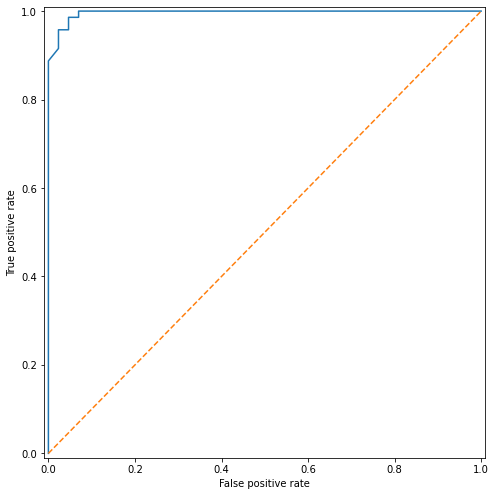

In [227]:
y_pred = cl.predict(X_test_cancer)
print('accuracy:', accuracy_score(y_test_cancer, y_pred))
print('auc:', roc_auc_score(y_test_cancer, y_pred))
probs = cl.predict_proba(X_test_cancer)
rows, cols = probs.shape
probs_d = [{ j: probs[i, j] for j in range(cols) } for i in range(rows)]
plot_roc_curve(y_test_cancer, probs_d)

xgboost

In [238]:
%%time
cl = xgb.XGBClassifier()
cl.fit(X_train_spam, y_train_spam)

/Users/nikitakonstantinovskiy/Documents/Bioinformatics/IB/ML/HW1/venv/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:49:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 3.08 s, sys: 60 ms, total: 3.14 s
Wall time: 285 ms


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

accuracy: 0.9587404994571118
auc: 0.9553672316384181


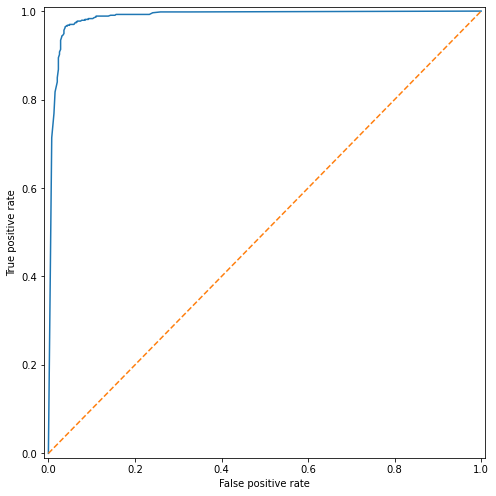

In [239]:
y_pred = cl.predict(X_test_spam)
print('accuracy:', accuracy_score(y_test_spam, y_pred))
print('auc:', roc_auc_score(y_test_spam, y_pred))
probs = cl.predict_proba(X_test_spam)
rows, cols = probs.shape
probs_d = [{ j: probs[i, j] for j in range(cols) } for i in range(rows)]
plot_roc_curve(y_test_spam, probs_d)

In [240]:
%%time
cl = xgb.XGBClassifier()
cl.fit(X_train_cancer, y_train_cancer)

[05:49:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 581 ms, sys: 30 ms, total: 611 ms
Wall time: 65 ms


/Users/nikitakonstantinovskiy/Documents/Bioinformatics/IB/ML/HW1/venv/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

accuracy: 0.956140350877193
auc: 0.9510317720275139


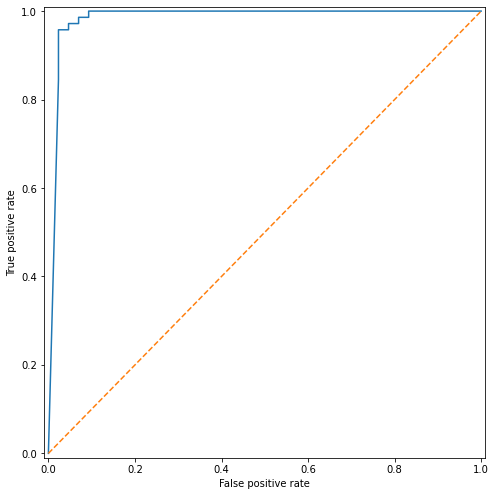

In [241]:
y_pred = cl.predict(X_test_cancer)
print('accuracy:', accuracy_score(y_test_cancer, y_pred))
print('auc:', roc_auc_score(y_test_cancer, y_pred))
probs = cl.predict_proba(X_test_cancer)
rows, cols = probs.shape
probs_d = [{ j: probs[i, j] for j in range(cols) } for i in range(rows)]
plot_roc_curve(y_test_cancer, probs_d)

Вывод можно сделать такой, что мой классификатор такой себе, все готовые классификаторы лучше по метрике аук, а по скорости обучения несравнимо быстрее